### Definición del problema

El análisis cluster pretende dividir la población en dos o más subgrupos, lo más diferentes posible entre ellos y lo más parecido posible dentro de ellos. Es decir, trata de minimizar la distancia intra grupos y aumentarla entre grupos. El análisis Cluster a diferencia de otras técnicas de clasificación, como el análisis discriminante, no necesita que los grupos estén predefinidos, sino que se crean a partir del proceso de clusterización.

Los datos han sido descargados de EUROSTAT, diponemos de las emisiones de gases de efecto invernadero por país y año desde el 1990. La información está en toneladas per cápita. El objetivo es relacionar unos países con otros en función de sus emisiones GHG (gases de efecto invernadero).

Principalmente vamos a hacer varias clasificaciones diferentes, basadas por un lado, en los países más y menos emisores, y por otro, en los páises que más o menos han reducido sus emisiones, incluso los que las han aumentado. 

Para ello hemos calculado una serie de variables que miden la diferencia de emisiones en diferentes intervalos de tiempo, 1990, 2000, 2010 y 2018. Así como sus valores en bruto (per cápita)

Como siempre comenzamos importando las librerías que serán usadas en el proyecto, así como los datos y la preparación de las variables rel10, rel20 y rel30 (que miden las emisiones relativas con respecto a hace 10, 20 y 30 años), y la tipificación de rel10 y a2018 (que mide las emisiones en ese año).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import scipy.cluster.hierarchy as sch

In [51]:
base_orig = pd.read_csv('GHG tonnes.csv',sep = ';')
base_orig.head(5)

,GEO,a1990,a1991,a1992,a1993,a1994,a1995,a1996,a1997,a1998,...,a2009,a2010,a2011,a2012,a2013,a2014,a2015,a2016,a2017,a2018
0,UE-27,11.7,11.4,11.1,10.8,10.8,10.9,11.1,10.9,10.8,...,9.5,9.7,9.5,9.3,9.1,8.8,8.9,8.9,8.9,8.7
1,UE-28,12.0,11.8,11.4,11.2,11.1,11.2,11.4,11.2,11.1,...,9.6,9.8,9.5,9.3,9.1,8.7,8.8,8.7,8.8,8.6
2,Belgium,15.0,15.2,15.1,14.9,15.3,15.5,15.9,15.1,15.6,...,12.1,12.7,11.6,11.3,11.2,10.6,11.0,10.8,10.8,10.8
3,Bulgaria,11.8,9.7,9.2,9.2,8.8,9.0,9.0,8.7,8.3,...,7.9,8.3,9.1,8.4,7.7,8.2,8.7,8.4,8.8,8.3
4,Czechia,19.3,17.6,16.9,16.2,15.4,15.4,15.6,15.2,14.6,...,13.3,13.5,13.4,12.9,12.4,12.2,12.3,12.5,12.4,12.2


In [50]:
# Variables relacion
base_orig["rel30"] = 100 * base_orig["a2018"] / base_orig["a1990"]
base_orig["rel20"] = 100 * base_orig["a2018"] / base_orig["a2000"]
base_orig["rel10"] = 100 * base_orig["a2018"] / base_orig["a2010"]

base_orig["avg10"] = base_orig[["a2018","a2017","a2016","a2015","a2014","a2013","a2012","a2011","a2010"]].mean(axis=1)
base_orig["wgh10"] = 100 * base_orig["avg10"] / base_orig["avg10"].sum()

# tipificamos algunas variables que seran usadas mas tarde, para combinar diferentes métricas

base_orig["avg_rel10"] = base_orig["rel10"].mean()
base_orig["std_rel10"] = base_orig["rel10"].std()

base_orig["avg_a2018"] = base_orig["a2018"].mean()
base_orig["std_a2018"] = base_orig["a2018"].std()

base_orig["rel10_st"] = (base_orig["rel10"] - base_orig["avg_rel10"]) / base_orig["std_rel10"]
base_orig["a2018_st"] = (base_orig["a2018"] - base_orig["avg_a2018"]) / base_orig["std_a2018"]

base_index = base_orig.set_index(['GEO']).sort_values('a2018', ascending = False)
base_index[['rel30','rel20','rel10','a2018','a2010','a2000']].head(5)

,rel30,rel20,rel10,a2018,a2010,a2000
GEO,,,,,,
Luxembourg,59.011628,83.539095,76.603774,20.3,26.5,24.3
Iceland,112.903226,107.361963,104.790419,17.5,16.7,16.3
Estonia,59.533074,123.387097,96.226415,15.3,15.9,12.4
Ireland,81.987578,71.739130,94.964029,13.2,13.9,18.4
Czechia,63.212435,82.993197,90.370370,12.2,13.5,14.7


### Análisis descriptivo

En segundo lugar, vamos a hacer un pequeño análisis descriptivo de los datos, para que de un rápido vistazo comencemos a sacar las primeras conclusiones.

Dibujamos un gráfico de barras verticales, con las emisiones del año 2018, y dos líneas, que representan la diferencia relativa con respecto a 2010 y 2000.

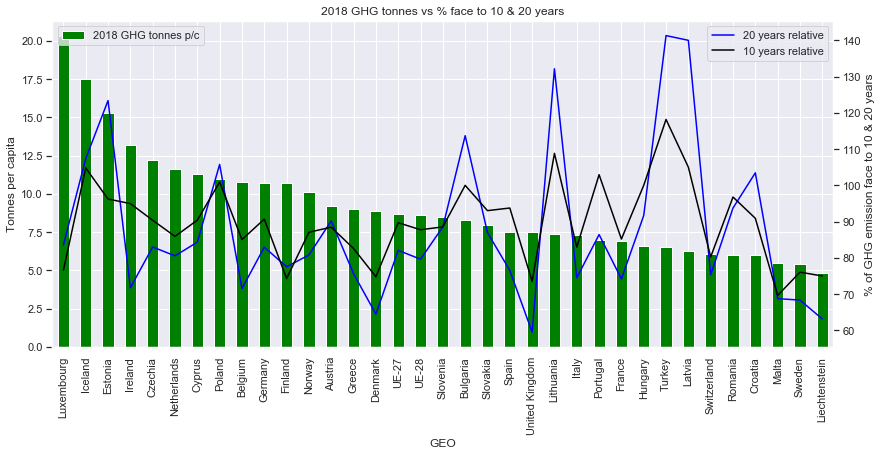

In [8]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111)
base_index.a2018.plot(kind = 'bar', color = 'green', ax=ax, label = '2018 GHG tonnes p/c')
plt.ylabel('Tonnes per capita')
ax2 = ax.twinx()
base_index.rel20.plot(kind = 'line', color = 'blue', ax=ax2, label  = '20 years relative')
base_index.rel10.plot(kind = 'line', color = 'black', ax=ax2, label = '10 years relative')
plt.title('2018 GHG tonnes vs % face to 10 & 20 years')
plt.ylabel('% of GHG emission face to 10 & 20 years')
ax.legend(loc=2)
ax2.legend(loc=1)
plt.grid(False)
plt.show()

Da para observar que Luxemburgo e Islandia son los países que más GHG emitieron en 2018, seguidos de Estonia, Irlanda y Rep.Checa, todos ellos con más de 12 toneladas anuales per cápita.

Por otro lado, llama la atención Turquía, que no es de los países más emisores, pero que sin embargo sí es el que más ha aumentado sus emisiones en las últimas décadas. Islandia también ha aumentado sus emisiones, siendo ya uno de los países más emisores.

Sin embargo Luxemburgo ha reducido drásticamente sus emisiones.

En el lado opuesto destacan Malta, Liechenstein y Suecia, con alrededor de 5 toneladas p/c en 2018, suponiendo éstas menos del 80% de las emisiones de 2010.

El gráfico de acontinuación permite ver desde otra perspectiva la misma información que la analizada recientemente.

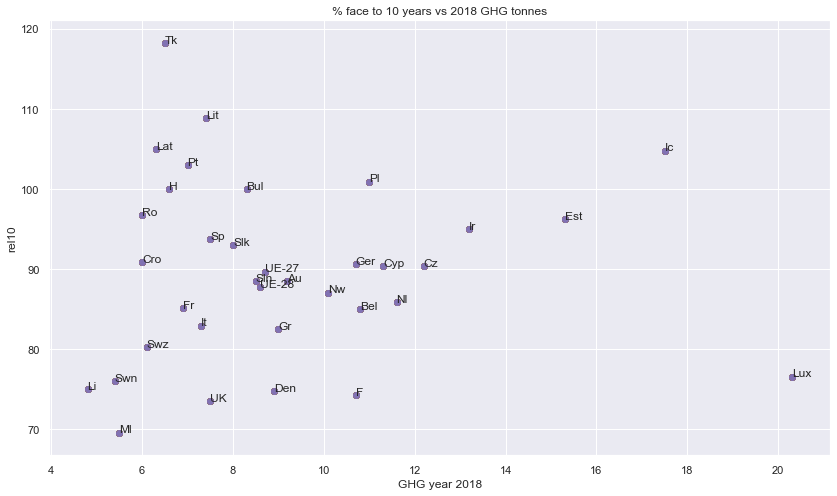

In [282]:
# Primero de todo, vamos a representar las diferentes variables por paises, para ver si visualmente hay diferencias

n = ['UE-27','UE-28','Bel','Bul','Cz','Den','Ger','Est','Ir','Gr','Sp','Fr','Cro','It','Cyp','Lat','Lit','Lux','H','Ml','Nl','Au','Pl','Pt','Ro','Sln','Slk','F','Swn','UK','Ic','Li','Nw','Swz','Tk']
plt.figure(figsize=(14, 8))
plt.ylabel('rel10')
plt.xlabel('GHG year 2018')
plt.title('% face to 10 years vs 2018 GHG tonnes')

for i, txt in enumerate(n):
    plt.scatter(base_index['a2018'],base_index['rel10'])
    plt.annotate(txt, (base_index["a2018"][i], base_index["rel10"][i]))
plt.show()

En el eje X vemos las emisiones per cápita de cada país en 2018, mientras que en el eje vertical representamos la diferencia relativa entre 2018 y 2010.

Por último es interesante saber cuánto de más emiten los países más contaminantes con respecto al resto, es realmente significativa esa diferencia?

En el gráfico de sectores representado a continuación, vemos que Luxemburgo marca la diferencia con un 6.7% de las emisiones. En torno a 3 veces más que España y 2,5 veces más que la media de la UE.

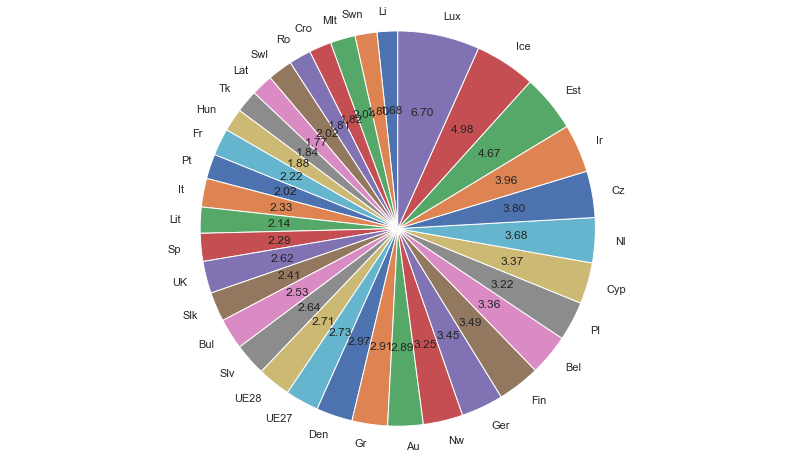

In [365]:
base_index = base_index.sort_values("a2018")

n2 = ['Li', 'Swn', 'Mlt', 'Cro', 'Ro', 'Swl','Lat', 'Tk', 'Hun', 'Fr', 'Pt', 'It','Lit', 'Sp', 'UK', 'Slk', 'Bul','Slv', 'UE28', 'UE27', 'Den', 'Gr', 'Au', 'Nw','Ger', 'Fin', 'Bel', 'Pl', 'Cyp', 'Nl','Cz', 'Ir', 'Est', 'Ice', 'Lux']
plt.figure(figsize=(14, 8))
plt.pie(base_index["wgh10"],labels=n2, autopct='%1.2f',startangle=90)

plt.axis('equal')
plt.show()


Con esta pequeña orientación de cuáles son los países más emisores por habitante, podemos comenzar a segmentar la población. 

Para ello lo primero que hay que hacer es eliminar los valores UE27 y UE28, ya que están directamente relacionados con el resto de valores.

In [23]:
# Retiramos Los valores UE-27 y UE-28 para calcular los cluster, ya que están correlacionados al resto de observaciones
base = base_orig[ ~ base_orig["GEO"].isin(["UE-27","UE-28"])]
base = base.set_index(['GEO'])

### Diferencias entre Jerárquico y No-Jerárquico

Exiten dos grandes formas de clusterizar una población, jerárquica y no-jerárquica. 

La principal diferencia entre ellas es la técnica que usan para construir los grupos. Una comienza desde arriba y la otra desde abajo. 

Con el método no jerárquico el usuario fija tantos centroides como categorías desee hacer y en el lugar que estime oportuno, y a partir de ahí cada punto es asignado al centroide más cercano. A continuación el nuevo centroide es calculado. El centroide inicial también puede ser asignado aleatoriamente.

Mientras que con el método jerárquico, inicialmente todos los puntos son considerados clusters,  y posteriormente cada punto es acercado al más próximo, creando estos dos un nuevo cluster. Que siguiendo el curso del proceso irá uniéndose con otros conglomerados, hasta finalmente crear uno solo con toda la población. A vista de dendograma se entiende mucho mejor.

El dendograma es un gráfico que permite ver cada paso del proceso de clusterización.

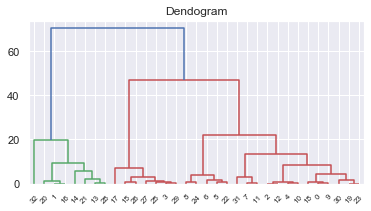

### Número de Clusters

Una pregunta muy frecuente, llegados a este punto, es cuántos grupos queremos o debemos hacer. En teoría cuantos más grupos hagamos menos dispersión va a haber dentro de cada grupo, lo cual es bueno, sin embargo si hacemos una división demasiado grande la interpretación de los grupos se hace demasiado complicada, y las diferencias no serían tan grandes como para ser tenidas en cuenta.

Para ello existen formas de medir el número óptimo de grupos. Basado en el SSE (Standard Squared Error), tenemos el método ELBOW. El modo de proceder de este método es calcular el SSE para diferentes modelos, cuya diferencia es que vamos incrementando el número de clusters en cada ejecución. 

De forma a posteriormente pintar el SSE de cada modelo en un gráfico, y visualmente ver a partir de qué número de clusters el modelo no gana tanto en eficiencia, es decir el SSE no disminuye lo suficiente como para añadir un nuevo Cluster al modelo. Esto se ve encontrando el punto de mayor curvatura. El método "KneeLocator" nos ayuda a encontrar ese punto.

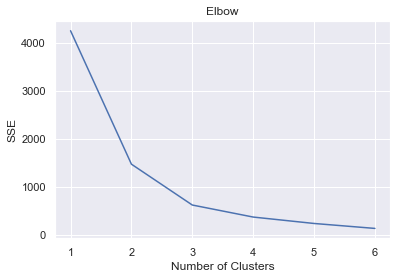

['rel10']  número de clusters recomendados:  3


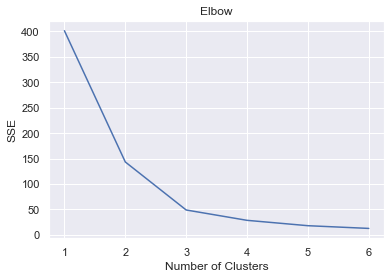

['a2018']  número de clusters recomendados:  3


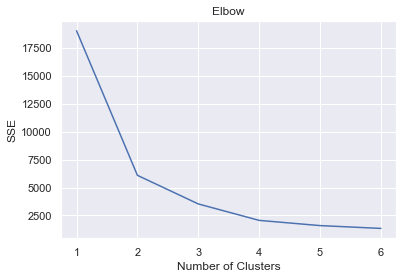

['rel10', 'rel20']  número de clusters recomendados:  2


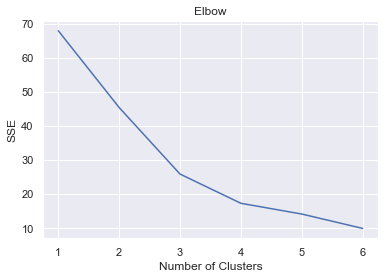

['rel10_st', 'a2018_st']  número de clusters recomendados:  3


In [362]:
ssea1  =[]; sser1 = []; sser2 = []; sser3 = []

def elbow_clus(list_out,list_in, plot):
    for i in range(1,7):
        list_out.append(KMeans(init="random",n_clusters=i,n_init=10,max_iter=300,random_state=None).fit(base[list_in]).inertia_)
    
    plt.plot(range(1, 7), list_out)
    plt.xticks(range(1, 7))
    plt.title ("Elbow")
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()
    kl = KneeLocator(range(1, 7), list_out, curve="convex", direction="decreasing")
    print(list_in," número de clusters recomendados: ", kl.elbow)  
    
elbow_clus(sser1,['rel10'],(0, 0))
elbow_clus(ssea1,['a2018'],(0, 1))
elbow_clus(sser2,['rel10','rel20'],(1, 0))
elbow_clus(sser3,['rel10_st','a2018_st'],(1, 1))

Por otro lado, diponemos del coeficiente de silhouette. Éste mide la separación y cohesión entre los clusters. Cuantifica cuánto de cerca está cada punto con respecto al resto de puntos dentro de su cluster y cuánto de lejos está con respecto a los puntos del resto de clusters. 

El rango de valores que toma este coeficiente varía entre 1 y -1. Cuanto mayor sea este número más proximo están situados los puntos dentro de sus cluster y más alejados del resto de grupos. Para la realización de este método también vamos a ejecutar diferentes modelos y ver en qué punto encontramos un mayor coeficiente de silhouette.



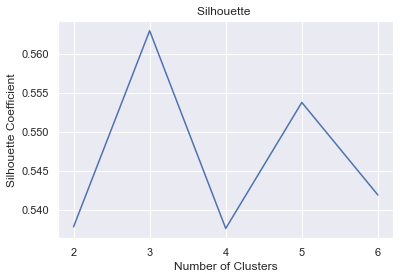

['rel10']


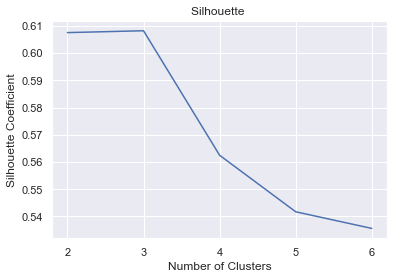

['a2018']


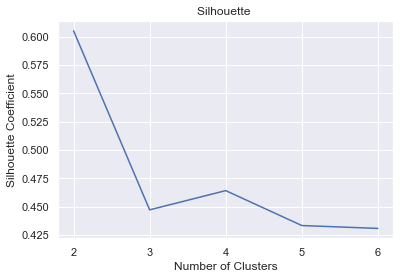

['rel10', 'rel20']


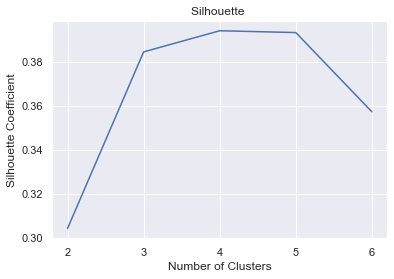

['rel10_st', 'a2018_st']


In [343]:
scr1 = []; sca1 = []; scr2 = []; scr3 = []

def silhouette_clus(list_out,list_in):
    for i in range(2,7):
        km = KMeans(n_clusters=i,n_init=10,max_iter=300,random_state=None).fit(base[list_in])
        score = silhouette_score(base[list_in], km.labels_)
        list_out.append(silhouette_score(base[list_in], km.labels_))
        
    plt.plot(range(2, 7), list_out)
    plt.xticks(range(2, 7))
    plt.title ("Silhouette ")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()   
    print(list_in)
    
silhouette_clus(scr1,['rel10'])
silhouette_clus(sca1,['a2018'])
silhouette_clus(scr2,['rel10','rel20'])
silhouette_clus(scr3,['rel10_st','a2018_st'])

Hemos probado diferentes combinaciones de variables explicativas del modelo. Segun ambos métodos, en la mayoría de modelos debemos hacer hasta un máximo de 3 grupos, excepto la combinación entre rel10 y rel20. Siguiendo el coeficiente de Silhouette, para el modelo con rel10 y a2018 estandarizados, podemos claisificar hasta en 4 grupos.

A continuación vemos una representación de las pruebas que hemos hecho con las diferentes variables.



### Análisis Cluster No Jerárquico

Comenzamos por un análisis Cluster no jerárquico, sobre la variable rel10, que explica la relación entre las emisiones de 2018 y las de 2010. En este método es olbigatorio indicar el número de clusters, en este caso 3.

Si en el argumento init indicamos "random" los centroides serán asignados aleatoriamente. Con "k-means++" el punto de convergencia es alcanzado de forma más eficiente.

n_init indica el número de inicializaciones, esto es importante ya que dos ejecucuiones del proceso pueden dar resultados diferentes, por lo que se realizan 10 repeticiones y devuleve el resultado de aquella ejecución con menor SSE

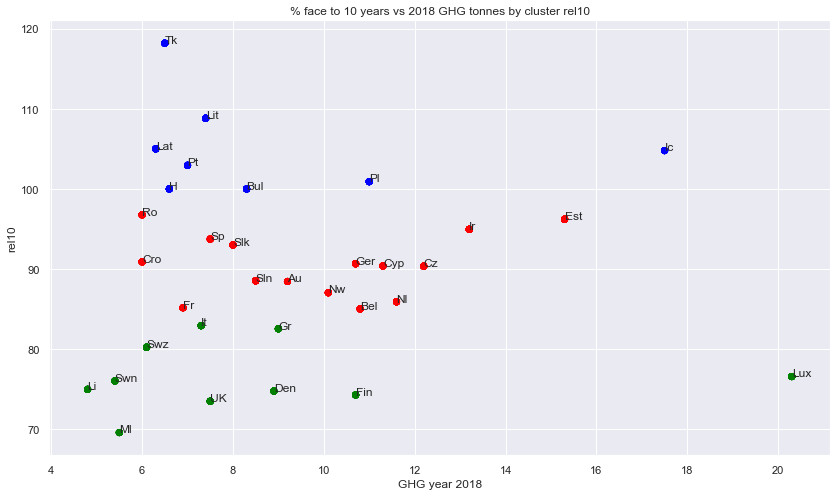

a2018                  a2010                       rel10        \
             mean count       std   mean count       std        mean count   
clus_rel10                                                                   
0           9.820    15  2.710087  10.86    15  2.911259   90.487865    15   
1           8.550    10  4.533395  11.17    10  5.919469   76.569176    10   
2           8.825     8  3.823891   8.45     8  3.735161  105.081797     8   

                      
                 std  
clus_rel10            
0           3.854386  
1           4.202618  
2           6.086005

In [350]:
predict = KMeans(init = "k-means++", n_clusters=3,n_init=10,max_iter=300,random_state=None).fit_predict(base[['rel10']])
predict
base["clus_rel10"] = predict

n = ['Bel','Bul','Cz','Den','Ger','Est','Ir','Gr','Sp','Fr','Cro','It','Cyp','Lat','Lit','Lux','H','Ml','Nl','Au','Pl','Pt','Ro','Sln','Slk','Fin','Swn','UK','Ic','Li','Nw','Swz','Tk']
colors = {0:'red', 1:'green', 2:'blue'}
plt.figure(figsize=(14, 8))
plt.ylabel('rel10')
plt.xlabel('GHG year 2018')
plt.title('% face to 10 years vs 2018 GHG tonnes by cluster rel10')
for i, txt in enumerate(n):
    plt.scatter(base['a2018'],base['rel10'], c=base["clus_rel10"].map(colors))
    plt.annotate(txt, (base["a2018"][i], base["rel10"][i]))
plt.show()

base[["a2018","a2010","rel10","clus_rel10"]].groupby("clus_rel10").agg(['mean','count','std'])

Como vemos han sido creados tres grupos, en función de si han reducido sus emisiones en los últimos 10 años, independientemente de si su nivel de emisiones es alto o bajo.

Analizando la tabla podemos ver que el grupo clus_rel10 = 0 representa los países que no han variado mucho sus emisiones en la última década, en media las emisiones se han reducido un 10%. En la categoría 1 tenemos los que sí han reducido sus emisiones, un 24% (columna rel10 -- mean). Por último el cluster 2 está comprendido por aquellos países que han aumentado sus emisiones, más de un 5% de media.


### Análisis Cluster Jerárquico

Para la siguiente prueba hemos realizado un análisis cluster jerárquico, también con 3 clusters. En este método no se especifican los centroides, ya que van surgiendo de las propias uniones entre observaciones y clusters.

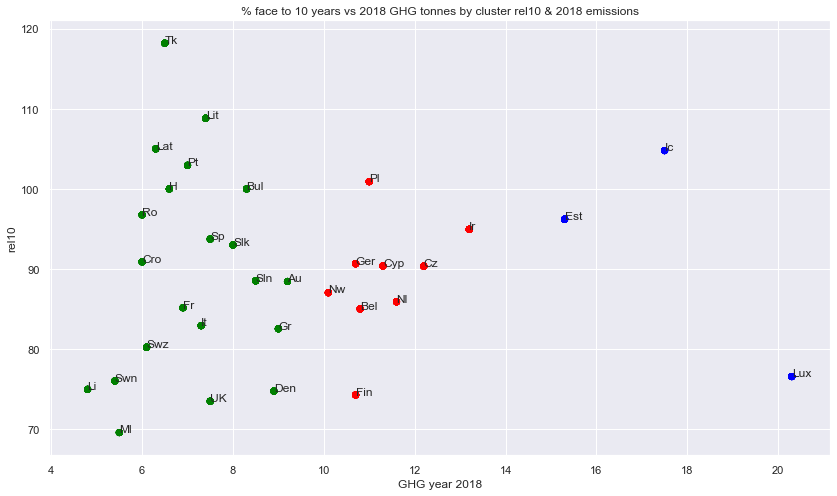

a2018                      a2010                      rel10  \
                mean count       std       mean count       std       mean   
ward_2018                                                                    
0           7.080952    21  1.252445   8.014286    21  1.756498  89.827328   
1          17.700000     3  2.505993  19.700000     3  5.902542  92.540203   
2          11.288889     9  0.936008  12.755556     9  1.166309  88.852179   

                            
          count        std  
ward_2018                   
0            21  12.990452  
1             3  14.450359  
2             9   7.321576

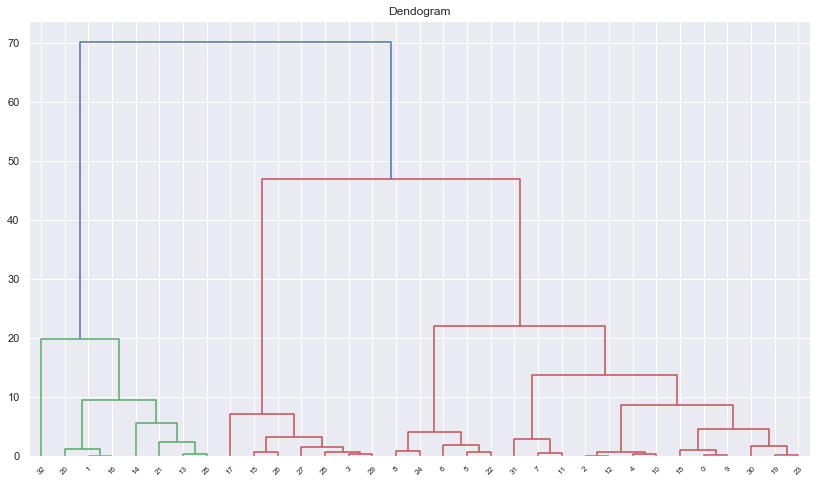

In [373]:
ward = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
ward = ward.fit_predict(base[['a2018']])
base["ward_2018"] = ward

n = ['Bel','Bul','Cz','Den','Ger','Est','Ir','Gr','Sp','Fr','Cro','It','Cyp','Lat','Lit','Lux','H','Ml','Nl','Au','Pl','Pt','Ro','Sln','Slk','Fin','Swn','UK','Ic','Li','Nw','Swz','Tk']
colors = {0:'green', 1:'blue', 2:'red',3:'purple'}

plt.figure(figsize=(14, 8))
plt.ylabel('rel10')
plt.xlabel('GHG year 2018')
plt.title('% face to 10 years vs 2018 GHG tonnes by cluster rel10 & 2018 emissions')
for i, txt in enumerate(n):
    plt.scatter(base['a2018'],base['rel10'], c=base["ward_2018"].map(colors))
    plt.annotate(txt, (base["a2018"][i], base["rel10"][i]))
plt.show()

plt.figure(figsize=(14, 8))
plt.title('Dendogram')
dendrogram = sch.dendrogram(sch.linkage(base[['rel10']], method='ward'))

base[["a2018","a2010","rel10","ward_2018"]].groupby("ward_2018").agg(['mean','count','std'])

Como podemos observar en el primer gráfico tenemos nuevamente tres grupos, pero esta vez solo teniendo en cuenta la variable a2018.

En la tabla descriptiva vemos como la media de a2018 en los diferentes grupos de la variable ward_2018 es significativamente diferente (primera columna).

Finalmente tenemos el dendograma, en el que vemos cómo las observaciones se van uniendo unas con otras formando grupos cada vez más grandes.

Ambas variables parecen buenas clasificadoras. A continuación vamos a realizar un análisis más complejo, añadiendo más variables a la ecuación y combinándolas entre ellas.


### Análisis Cluster con dos Variables

Comenzamos incluyendo la variable rel20, que explica el porcentage de emisiones de 2018 con respecto a 2000. Vamos a cruzarla con rel10, utilizando un método jerárquico.

Siguiendo el resultado de los métodos de Elbow y Silhouette, para la definición del número óptimo de clusters, vamos a crear 2 grupos para este nuevo modelo.


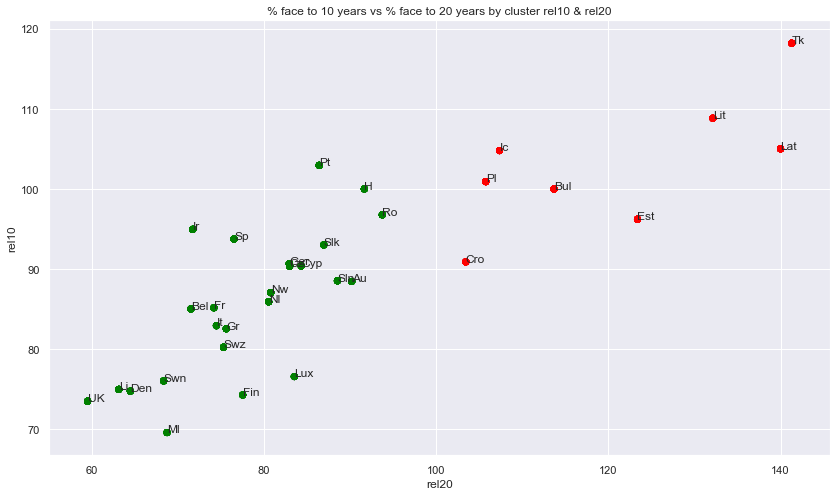

In [372]:
ward = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward')
ward = ward.fit_predict(base[['rel10','rel20']])
base["rel10_rel20"] = ward

n = ['Bel','Bul','Cz','Den','Ger','Est','Ir','Gr','Sp','Fr','Cro','It','Cyp','Lat','Lit','Lux','H','Ml','Nl','Au','Pl','Pt','Ro','Sln','Slk','Fin','Swn','UK','Ic','Li','Nw','Swz','Tk']
colors = {0:'green', 1:'red', 2:'blue',3:'purple'}

plt.figure(figsize=(14, 8))
plt.ylabel('rel10')
plt.xlabel('rel20')
plt.title('% face to 10 years vs % face to 20 years by cluster rel10 & rel20')
for i, txt in enumerate(n):
    plt.scatter(base['rel20'],base['rel10'], c=base["rel10_rel20"].map(colors))
    plt.annotate(txt, (base["rel20"][i], base["rel10"][i]))
plt.show()

Con esta nueva clusterización se observan 2 grupos claramente diferenciados. El conglomerado verde alberga los países que más han reducido sus emisiones en las últimas décadas, entre ellos UK y Malta.

El grupo rojo se diferencia del verde en que todos los países ahí comprendidos han aumentado sus emisiones con respecto al año 2000, y solo Croacia ha reducido, ligeramente, con respecto a 2010.


### Análisis Cluster con dos variables desescaldas

Para finalizar vamos a conglomerar a través de las variables rel10 y a2018. Este modelo contiene una dificultad añadida, y es que las dos variables tienen escalas diferentes, por lo que se requiere una transformación matemática para hacerlas compatibles. Esto es, tipificarlas, sustraer la media y dividir por la desviación típica (Esta transformación está en los primeros cuadros de código).

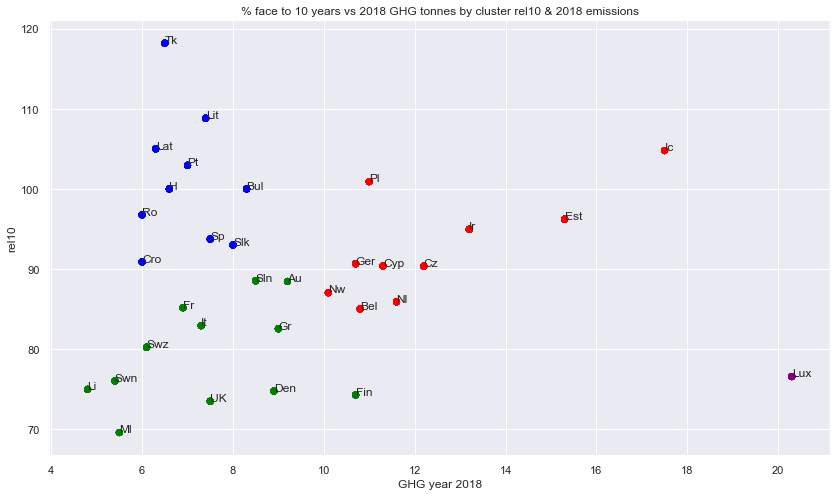

a2018               rel10            
          mean count   std    mean count   std
cluster                                       
Blue      6.96    10  0.82  100.94    10  8.26
Green     7.48    12  1.82   79.27    12  6.25
Purple   20.30     1  0.00   76.60     1  0.00
Red      12.37    10  2.35   92.64    10  6.52

In [36]:
ward = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
ward = ward.fit_predict(base[['rel10_st','a2018_st']])
base["rel10_2018_st_ward"] = ward

n = ['Bel','Bul','Cz','Den','Ger','Est','Ir','Gr','Sp','Fr','Cro','It','Cyp','Lat','Lit','Lux','H','Ml','Nl','Au','Pl','Pt','Ro','Sln','Slk','Fin','Swn','UK','Ic','Li','Nw','Swz','Tk']
colors = {0:'red', 1:'blue', 2:'green',3:'purple'}

plt.figure(figsize=(14, 8))
plt.ylabel('rel10')
plt.xlabel('GHG year 2018')
plt.title('% face to 10 years vs 2018 GHG tonnes by cluster rel10 & 2018 emissions')
for i, txt in enumerate(n):
    plt.scatter(base['a2018'],base['rel10'], c=base["rel10_2018_st_ward"].map(colors))
    plt.annotate(txt, (base["a2018"][i], base["rel10"][i]))
plt.show()

#base = base.reset_index()

base.loc[base['rel10_2018_st_ward'] == 0, 'cluster'] = 'Red'
base.loc[base['rel10_2018_st_ward'] == 1, 'cluster'] = 'Blue'
base.loc[base['rel10_2018_st_ward'] == 2, 'cluster'] = 'Green'
base.loc[base['rel10_2018_st_ward'] == 3, 'cluster'] = 'Purple'
base[["a2018","rel10","cluster"]].groupby("cluster").agg(['mean','count','std']).fillna(0).round(2)

En este caso tenemos cuatro grupos, uno de ellos contiene solo una observación, Luxemburgo. Al no encontrar asociación con otros cluster éste ha quedado solo.

El resto de grupos se distribuyen de forma más o menos similar a los modelos anteriores, los países menos emisores y que más han reducido por un lado, por otro los que emiten poco pero prácticamente no reducen y finalmente los que emiten más.

### Conclusiones

En primer lugar cabe destacar que hay claras diferencias entre los países de la UE, con respecto a sus emisiones GHG. Principalmente en el volumen de toneladas de gases de efecto invernadero emitido. Por otr lado se distinguen unos países que sí han reducido sus emisiones con respecto a 2000 y 2010, mientras que otros no.

Un punto de mejora para este modelo sería encontrar variables que explicasen el comportamiento de países como Luxemburgo o Islandia. Ya que son países a la vanguardia en muchos aspectos sociales y económicos, y sorprende el alto consumo per cápita de Luxemburgo y la no reducción de GHG por parte de Islandia.

Una posible explicación, en el caso de Luxemburgo, es que su número de habitantes es muy inferior al número de trabajadores transfronterizos y de personas que pasan el día en el país. Esto supone un alto volumen de personas emitiendo gases dividido entre una población pequeña. ¿Por qué no ocurre lo mismo con Liechestein? Siendo ambos países con carácterísticas similares.

¿El alto consumo de Islandia está relacionado con su modelo de producción de energía geotérmica? 

In [49]:
base[['rel30','rel20','rel10','a2018','a2010','a2000','cluster']].round(2).sort_values('a2018', ascending=False)

,rel30,rel20,rel10,a2018,a2010,a2000,cluster
GEO,,,,,,,
Luxembourg,59.01,83.54,76.60,20.3,26.5,24.3,Purple
Iceland,112.90,107.36,104.79,17.5,16.7,16.3,Red
Estonia,59.53,123.39,96.23,15.3,15.9,12.4,Red
Ireland,81.99,71.74,94.96,13.2,13.9,18.4,Red
Czechia,63.21,82.99,90.37,12.2,13.5,14.7,Red
Netherlands,76.82,80.56,85.93,11.6,13.5,14.4,Red
Cyprus,101.80,84.33,90.40,11.3,12.5,13.4,Red
Poland,88.00,105.77,100.92,11.0,10.9,10.4,Red
Belgium,72.00,71.52,85.04,10.8,12.7,15.1,Red
